#### Dependencies
____

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

from fbprophet import Prophet
from statsmodels.tools.eval_measures import rmse
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

%matplotlib inline

#### Load Data
____

In [2]:
dataset = '../resources/daily_household_power_consumption.csv'

master = pd.read_csv(dataset, infer_datetime_format=True, parse_dates=['datetime'] )
master = master[['datetime', 'Global_active_power']]
master.columns = ['ds', 'y']

master.head()

,ds,y
0,2006-12-16,1209.176
1,2006-12-17,3390.460
2,2006-12-18,2203.826
3,2006-12-19,1666.194
4,2006-12-20,2225.748


#### Split Train and Test Data
____

In [24]:
prediction_days = 90
cutoff_date = master['ds'].max() - pd.Timedelta(days=prediction_days)

cond_train = master['ds'] <= cutoff_date  
cond_test  = master['ds'] > cutoff_date    # max forecast time = 1 year

test = master[cond_test]
train = master[cond_train]

print(f'Train : {train.shape} - Test : {test.shape}\n')
print(f'Train Range : \n\tFrom : {train["ds"].min()} To : {train["ds"].max()}')
print(f'Test Range : \n\tFrom : {test["ds"].min()} To : {test["ds"].max()}')

Train : (1352, 2) - Test : (90, 2)

Train Range : 
	From : 2006-12-16 00:00:00 To : 2010-08-28 00:00:00
Test Range : 
	From : 2010-08-29 00:00:00 To : 2010-11-26 00:00:00


#### Create and Fit the Model
____

In [73]:
model = Prophet(seasonality_mode='multiplicative').fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Perform Predictions
____

In [74]:
predictions = model.make_future_dataframe(periods=prediction_days, freq='D')
forecast = model.predict(predictions)

forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat']].tail(10)

,ds,yhat_lower,yhat_upper,yhat
1432,2010-11-17,1498.078724,2585.473277,2029.078095
1433,2010-11-18,1369.635568,2399.821299,1893.861791
1434,2010-11-19,1471.210697,2558.267484,2014.447833
1435,2010-11-20,1797.334259,2859.211352,2314.667459
1436,2010-11-21,1767.648976,2832.802002,2304.028037
1437,2010-11-22,1424.315199,2521.334526,1975.456615
1438,2010-11-23,1585.075918,2600.394702,2101.319368
1439,2010-11-24,1581.712507,2700.693959,2122.233002
1440,2010-11-25,1442.639303,2520.953692,1961.810470
1441,2010-11-26,1523.388426,2574.701626,2057.735277


#### Plot Results
____

##### Forecast

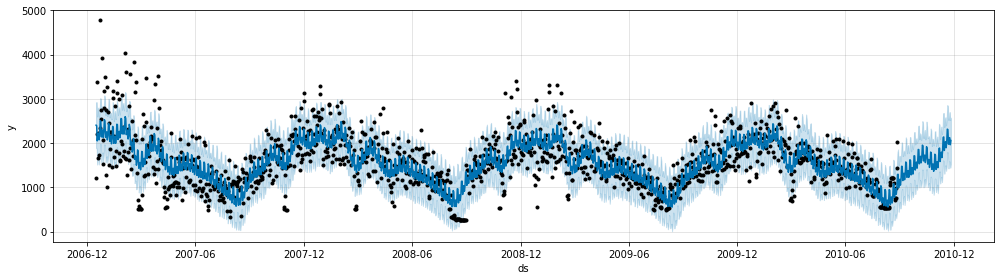

In [75]:
model.plot(forecast, figsize=(14,4));

plt.tight_layout()

##### Components


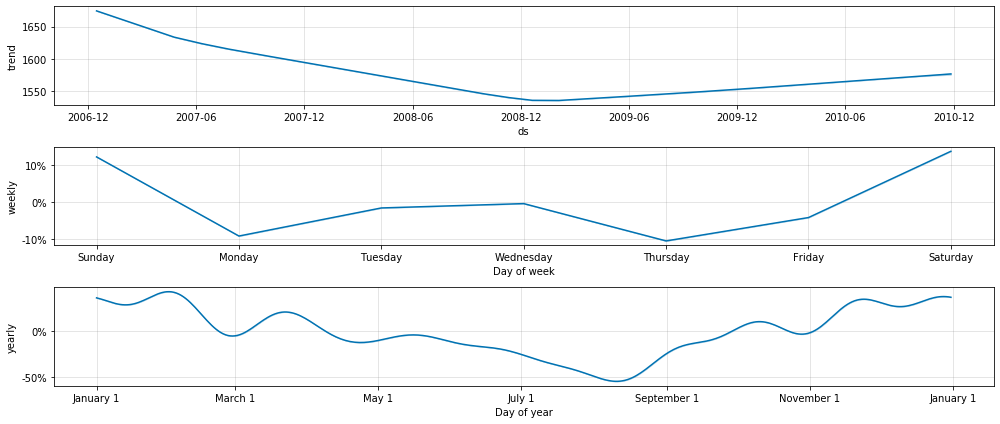

In [76]:
model.plot_components(forecast,figsize=(14,6))

# power consume increase over weekends and from fall to spring
plt.tight_layout()

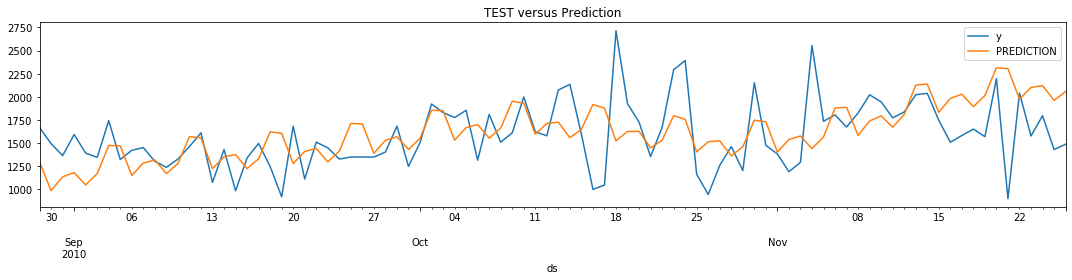

In [77]:
model_data = test.copy(deep=True)
model_data.set_index('ds', inplace=True)
model_data.index.freq='D'

pd.plotting.register_matplotlib_converters()

model_data.plot(legend=True, label='TEST', figsize=(15,4),title='TEST versus Prediction')

pred_data = forecast.copy(deep=True)
pred_data.set_index('ds', inplace=True)
pred_data.index.freq='D'
pred_data = pred_data.iloc[-prediction_days:]
pred_data['yhat'].plot(legend=True, label='PREDICTION', figsize=(15,4))

plt.tight_layout()

#### Prediction evaluation
____

In [78]:
print(f'Mean : {model_data["y"].mean()} - Standard Deviation : {model_data["y"].std()} - Root Mean Square : {rmse(x1 = pred_data["yhat"], x2 = model_data["y"])}')


Mean : 1580.5537999999997 - Standard Deviation : 357.9458043948409 - Root Mean Square : 383.3463023688979


#### Cross Validation
_____

INFO:fbprophet:Making 4 forecasts with cutoffs between 2009-12-01 00:00:00 and 2010-03-01 00:00:00


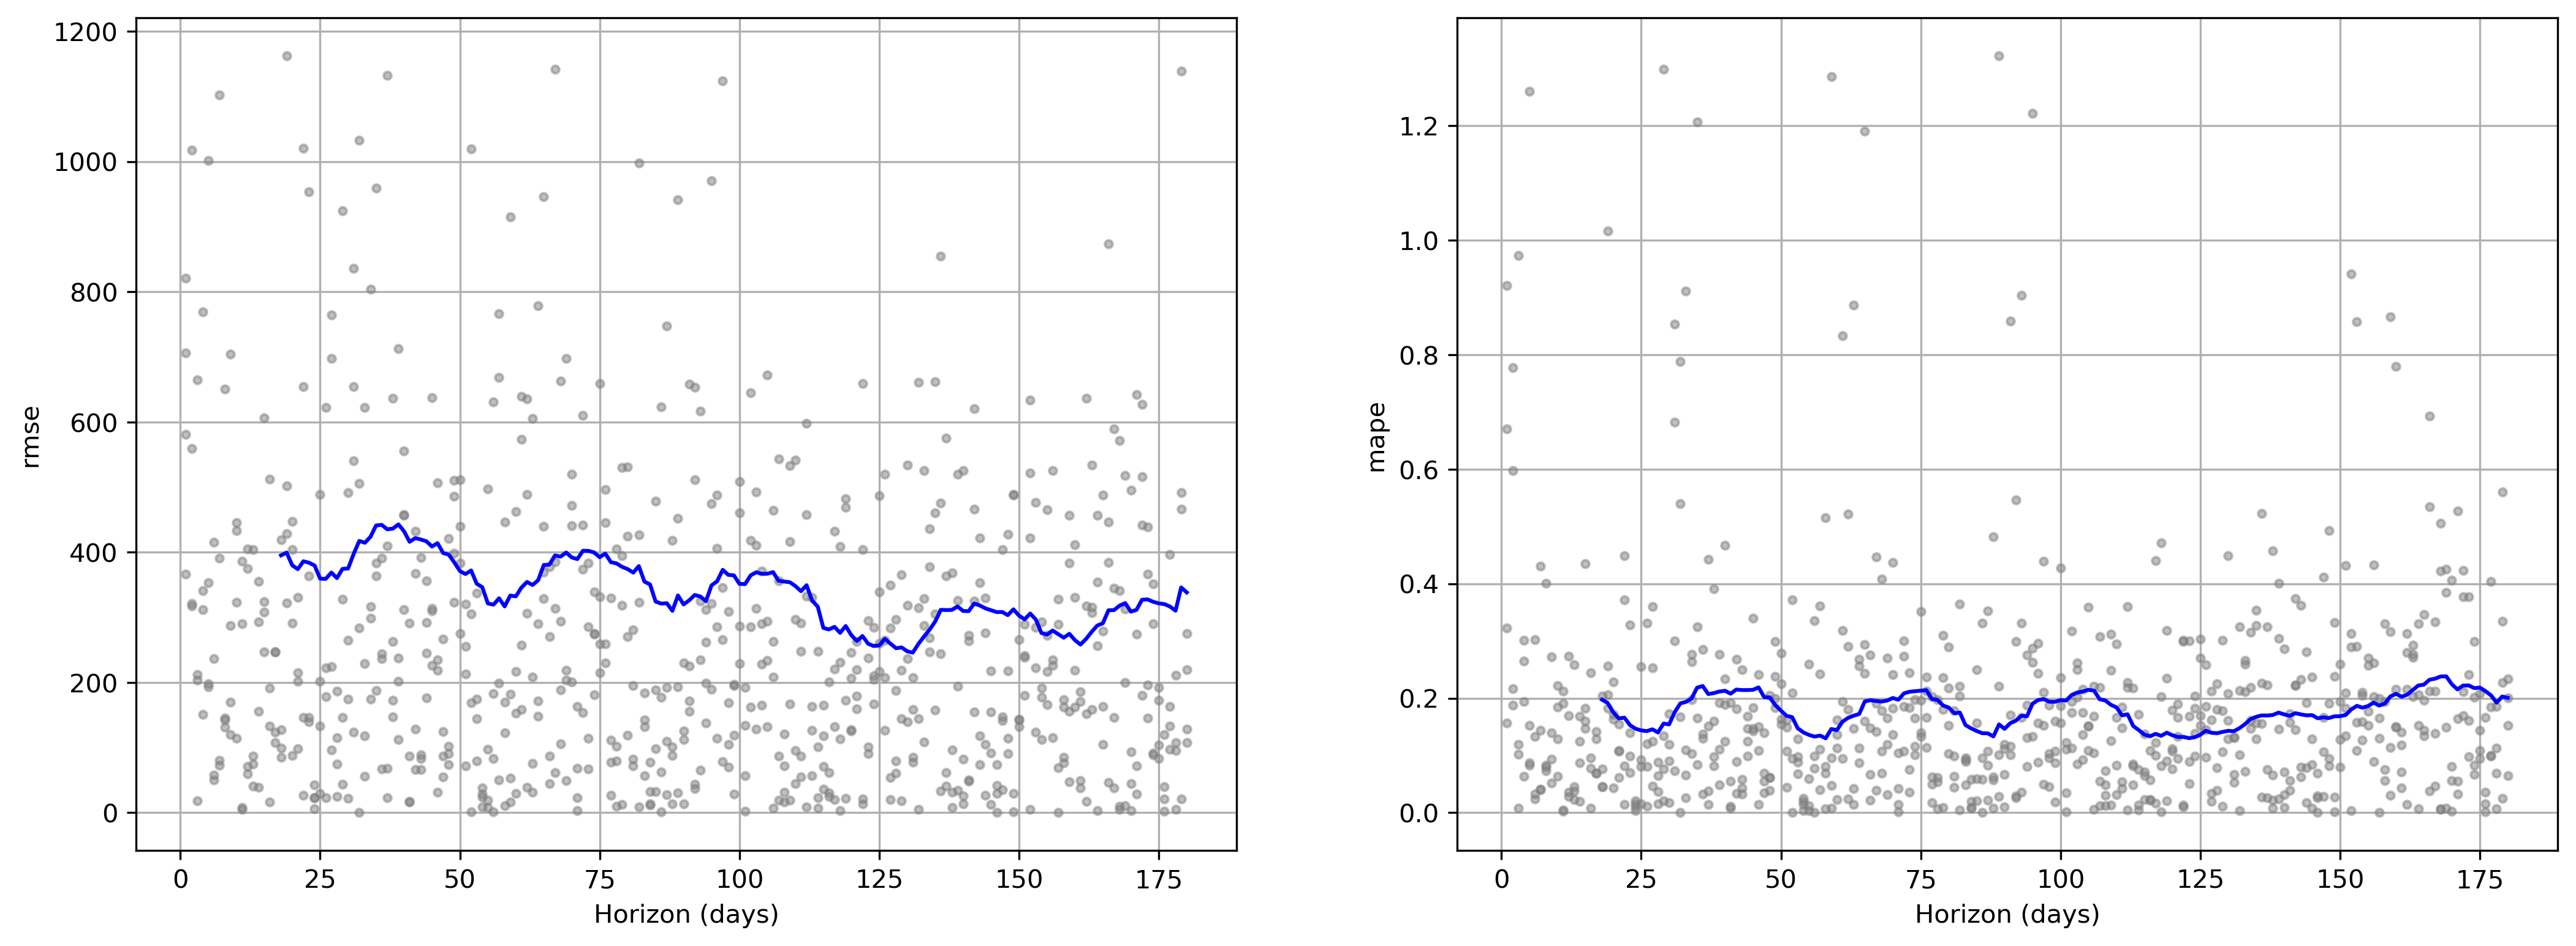

In [79]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,6), dpi=300)
df_cv = cross_validation(model, initial='1052 days', period='30 days', horizon='180 days')

plot_cross_validation_metric(df_cv, metric='rmse', ax=axes[0]);
plot_cross_validation_metric(df_cv, metric='mape', ax=axes[1]);